In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

### Load the dataset

path_to_dataset = 'FinalData.csv'
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')

    #CHANGE THIS
    colab_path = "/content/drive/MyDrive/Colab Notebooks/NTU_DA/"
    path_to_dataset = colab_path + path_to_dataset

    IN_COLAB = True
except:
    IN_COLAB = False

df = pd.read_csv(path_to_dataset, parse_dates=True)
df["day_in_a_week"] = pd.to_datetime(df["datetime"]).dt.dayofweek #Get the day in a week
df["month"] = pd.to_datetime(df["datetime"]).dt.month #Get month

## Removing unnecessary features

df = df.drop('datetime', axis=1) #We remove the date
df = df.drop("day", axis = 1) #We remove the day
df = df.drop("next_dist", axis = 1)
df = df.drop("bus_cnt", axis = 1)
df = df.drop("bike_cnt", axis = 1)
df = df.drop("school_cnt", axis = 1)

In [2]:
#Dataset information
# categorical_variables = ["mrt_station", "hour", "day", "status", "day_in_a_week", "month"]
categorical_variables = ["mrt_station", "hour", "status", "day_in_a_week", "month"]

y_ind = df.columns.get_loc("mrt_flow")
cat_indices = [df.columns.get_loc(categorical_variables[i]) for i in range(len(categorical_variables))]
real_indices = [i for i in list(range(0, len(df.columns))) if (i not in cat_indices and i != y_ind)]
print("metro_flow index: ", y_ind, "\ncategorical indices: ", cat_indices, "\nnumerical indices: ", real_indices)


unique_station_names = list(dict.fromkeys([df["mrt_station"][i] for i in range(len(df))]))
unique_status        = list(dict.fromkeys([df["status"][i] for i in range(len(df))]))
print("\n")
category_cnt = 0
for var in categorical_variables:
    unique_vals = list(dict.fromkeys([df[var][i] for i in range(len(df))]))
    print(str(len(unique_vals)) + " unique " + var + ":\t", unique_vals)
    category_cnt += len(unique_vals)


metro_flow index:  1 
categorical indices:  [0, 2, 10, 26, 27] 
numerical indices:  [3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


7 unique mrt_station:	 ['中山', '北投', '北門', '古亭', '士林', '大橋頭', '松山']
24 unique hour:	 [0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 2, 3, 4]
5 unique status:	 ['良好', '普通', '對敏感族群不健康', nan, '對所有族群不健康']
7 unique day_in_a_week:	 [2, 3, 4, 5, 6, 0, 1]
12 unique month:	 [6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5]


In [3]:
import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.compose
import sklearn.linear_model

data = df.to_numpy()


#Convert station names to ints
print("Processing station names")
for i in range(len(unique_station_names)):
    print("\tFirst occurance of " + unique_station_names[i] + ":", np.nonzero(data == unique_station_names[i])[0][0])
    data[data == unique_station_names[i]] = i

print("\nProcessing station status")
#Convert status names to ints
for i in range(len(unique_status)):
    occurances = np.nonzero(data == unique_status[i])[0]
    if len(occurances) > 0:
        print("\tFirst occurance of " + str(unique_status[i]) + ":", occurances[0])
    data[data == unique_status[i]] = i

#Replace missing values with NaNs
data[data == "-"] = np.nan

##Train test split
train_split_ratio = 0.7
val_split_ratio = 0.1
test_split_ratio = 0.2

sample_cnt = data.shape[0]
train_sz = int(train_split_ratio * sample_cnt)
val_sz = int(val_split_ratio * sample_cnt)
test_sz = int(test_split_ratio * sample_cnt)

val_ind = train_sz + val_sz
test_ind = val_ind + test_sz

print("\nTrain-val-test split")
print("\tTrain start index:", 0)
print("\tVal start index:", train_sz)
print("\tTest start index:", val_ind)

Y_train_raw = data[:train_sz, y_ind][:, None]
X_train_raw = data[:train_sz, cat_indices + real_indices]

Y_val_raw = data[train_sz:val_ind, y_ind][:, None]
X_val_raw = data[train_sz:val_ind, cat_indices + real_indices]

Y_test_raw = data[val_ind:test_ind, y_ind][:, None]
X_test_raw = data[val_ind:test_ind, cat_indices + real_indices]

##Preprocessing
new_cat_indices = list(range(len(cat_indices)))
new_real_indices = list(range(len(cat_indices), len(cat_indices) + len(real_indices)))

#One hot encoding for categories, Robust scaling for numerical values
X_preprocessor = sklearn.compose.ColumnTransformer(
    transformers=[
        ("cat", sklearn.preprocessing.OneHotEncoder(categories='auto', handle_unknown="ignore"), new_cat_indices),
        ("num", sklearn.preprocessing.RobustScaler(), new_real_indices)
    ]
)
X_preprocessor.fit(X_train_raw)
X_train = X_preprocessor.transform(X_train_raw)
X_val   = X_preprocessor.transform(X_val_raw)
X_test  = X_preprocessor.transform(X_test_raw)

Processing station names
	First occurance of 中山: 0
	First occurance of 北投: 1
	First occurance of 北門: 2
	First occurance of 古亭: 3
	First occurance of 士林: 4
	First occurance of 大橋頭: 5
	First occurance of 松山: 6

Processing station status
	First occurance of 良好: 0
	First occurance of 普通: 54
	First occurance of 對敏感族群不健康: 7556
	First occurance of 對所有族群不健康: 15096

Train-val-test split
	Train start index: 0
	Val start index: 52361
	Test start index: 59841


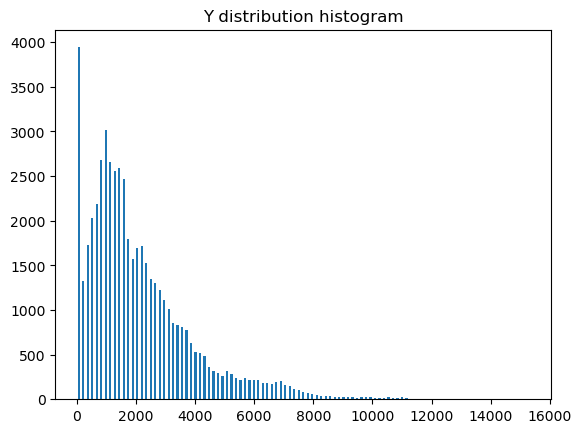

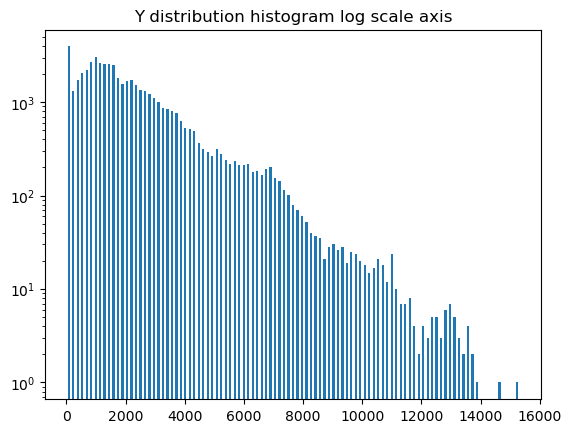

In [4]:
step = Y_train_raw.max() / 100
e = 0.00001
bins = np.arange(Y_train_raw.min() - e, Y_train_raw.max() + step, step)

plt.hist(Y_train_raw, bins=bins, rwidth = 0.5)
plt.title("Y distribution histogram")
plt.show()

plt.hist(Y_train_raw, bins=bins, rwidth = 0.5)
plt.gca().set_yscale('log')
plt.title("Y distribution histogram log scale axis")
plt.show()

# Y_train_raw_mod = np.log(Y_train_raw.astype(float) + 1)
# step = Y_train_raw_mod.max() / 100
# bins = np.arange(Y_train_raw_mod.min() - e, Y_train_raw_mod.max() + step, step)
# plt.hist(Y_train_raw_mod, bins=bins, rwidth = 0.5)
# plt.title("Y distribution histogram log scale values")
# plt.show()

# Transforming Y
Y_scaler = sklearn.preprocessing.RobustScaler().fit(Y_train_raw)
Y_train = Y_scaler.transform(Y_train_raw)
Y_val   = Y_scaler.transform(Y_val_raw)
Y_test  = Y_scaler.transform(Y_test_raw)

def Y_inverse_transform(Y):
    return Y_scaler.inverse_transform(Y)

# #We apply log scaling for Y
# Y_train_raw_log = np.log(Y_train_raw.astype(float) + 1)
# Y_val_raw_log   = np.log(Y_val_raw.astype(float) + 1)
# Y_test_raw_log  = np.log(Y_test_raw.astype(float) + 1)

# print(Y_train_raw_log.min(), Y_train_raw_log.max())

# #Robust scaling for Y
# Y_scaler = sklearn.preprocessing.RobustScaler().fit(Y_train_raw_log)
# Y_train = Y_scaler.transform(Y_train_raw_log)
# Y_val   = Y_scaler.transform(Y_val_raw_log)
# Y_test  = Y_scaler.transform(Y_test_raw_log)

# def Y_inverse_transform(Y):
#   return np.exp(Y_scaler.inverse_transform(Y)) - 1

#Replace NaNs with zeros
X_train[np.isnan(X_train)] = 0
X_val[np.isnan(X_val)] = 0
X_test[np.isnan(X_test)] = 0

# Sklearn Linear Regression

In [5]:
LR = sklearn.linear_model.LinearRegression(n_jobs=-1).fit(X_train, Y_train)

def print_metrics(X, Y):
    Y_hat = LR.predict(X)

    MSE = np.mean((Y_hat - Y) ** 2)
    orig_MSE = np.mean((Y_inverse_transform(Y_hat) - Y_inverse_transform(Y)) ** 2)
    print("\tMSE:", MSE)
    print("\tOriginal scale MSE:", orig_MSE)

    print("\n\tRMSE:", np.sqrt(MSE))
    print("\tOriginal scale RMSE:", np.sqrt(orig_MSE))

    print("\n\tMAE:", np.mean(np.abs(Y_hat - Y)))
    print("\tOriginal scale MAE:", np.mean(np.abs(Y_inverse_transform(Y_hat) - Y_inverse_transform(Y))))

print("Train metrics:")
print_metrics(X_train, Y_train)
print("\nValidation metrics:")
print_metrics(X_val, Y_val)
print("\nTest metrics:")
print_metrics(X_test, Y_test)

# removed_variables = []
# for i in range(1, X_train.shape[1]):
    
#     x_vars = [ii for ii in range(X_train.shape[1]) if ii != i and ii not in removed_variables]
#     LR = sklearn.linear_model.LinearRegression(n_jobs=-1).fit(X_train[:, x_vars], X_train[:, i])

#     tol = 1e-2
#     MSE = np.mean((LR.predict(X_train[:, x_vars]) - X_train[:, i]) ** 2 )
#     print("{} MSE:{}".format(i, MSE))
#     if tol > MSE:
#         removed_variables.append(i)

Train metrics:
	MSE: 0.1999268552936146
	Original scale MSE: 801307.6357242285

	RMSE: 0.4471318097536951
	Original scale RMSE: 895.1578831268976

	MAE: 0.3033293397144254
	Original scale MAE: 607.2653381082796

Validation metrics:
	MSE: 0.2376731893330603
	Original scale MSE: 952595.093539663

	RMSE: 0.4875173733653605
	Original scale RMSE: 976.0097814774517

	MAE: 0.31990965927038906
	Original scale MAE: 640.459137859319

Test metrics:
	MSE: 0.2788496678109402
	Original scale MSE: 1117630.5839849196

	RMSE: 0.5280621817655002
	Original scale RMSE: 1057.1804878945316

	MAE: 0.34287533518763486
	Original scale MAE: 686.436421045645


# Sklearn MLP

In [6]:
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor(max_iter=2000, hidden_layer_sizes = (1000)).fit(X_train, np.ravel(Y_train))

def print_metrics(X, Y):
    Y_hat = MLP.predict(X)[:, None]

    MSE = np.mean((Y_hat - Y) ** 2)
    orig_MSE = np.mean((Y_inverse_transform(Y_hat) - Y_inverse_transform(Y)) ** 2)
    print("\tMSE:", MSE)
    print("\tOriginal scale MSE:", orig_MSE)

    print("\n\tRMSE:", np.sqrt(MSE))
    print("\tOriginal scale RMSE:", np.sqrt(orig_MSE))

    print("\n\tMAE:", np.mean(np.abs(Y_hat - Y)))
    print("\tOriginal scale MAE:", np.mean(np.abs(Y_inverse_transform(Y_hat) - Y_inverse_transform(Y))))

print("Train metrics:")
print_metrics(X_train, Y_train)
print("\nValidation metrics:")
print_metrics(X_val, Y_val)
print("\nTest metrics:")
print_metrics(X_test, Y_test)

Train metrics:
	MSE: 0.024127495099620335
	Original scale MSE: 96703.09686925869

	RMSE: 0.15533027747229558
	Original scale RMSE: 310.97121549953573

	MAE: 0.077202286893705
	Original scale MAE: 154.5589783611974

Validation metrics:
	MSE: 0.07784139055429351
	Original scale MSE: 311988.6047071706

	RMSE: 0.2790006999172108
	Original scale RMSE: 558.559401234256

	MAE: 0.1506101254878134
	Original scale MAE: 301.52147122660244

Test metrics:
	MSE: 0.09405094674816011
	Original scale MSE: 376956.57077041274

	RMSE: 0.3066772680655678
	Original scale RMSE: 613.9678906672667

	MAE: 0.17189247956696904
	Original scale MAE: 344.128744093072


# PyTorch initialization

In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import copy
import time

default_dtype = torch.float32
torch.set_default_dtype(default_dtype)

#Initialize PyTorch
USE_CUDA = True

cuda_available = torch.cuda.is_available()
print("Cuda available: ", cuda_available)
print("Using Cuda: ", USE_CUDA)

if cuda_available:
  # print(torch.cuda.current_device())
  # print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
  cuda_device = torch.device("cuda:0")

#Move the dataset to GPU
input_size = X_train.shape[1]
X_train_t = torch.from_numpy(X_train).to(dtype = default_dtype)
X_val_t   = torch.from_numpy(X_val  ).to(dtype = default_dtype)
X_test_t  = torch.from_numpy(X_test ).to(dtype = default_dtype)
Y_train_t = torch.from_numpy(Y_train).to(dtype = default_dtype)
Y_val_t   = torch.from_numpy(Y_val  ).to(dtype = default_dtype)
Y_test_t  = torch.from_numpy(Y_test ).to(dtype = default_dtype)

if USE_CUDA and cuda_available:
    X_train_t = X_train_t.cuda()
    X_val_t   = X_val_t.cuda()
    X_test_t  = X_test_t.cuda()
    Y_train_t = Y_train_t.cuda()
    Y_val_t   = Y_val_t.cuda()
    Y_test_t  = Y_test_t.cuda()

loss_functions = {
    'SmoothL1': F.smooth_l1_loss,
    'L1': F.l1_loss,
    'MSE': F.mse_loss
}

Cuda available:  True
Using Cuda:  True
NVIDIA GeForce RTX 4070


# PyTorch training implementation

In [8]:
##Initialize model weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    torch.nn.init.xavier_uniform_(layer_in.weight, gain=0.5)
    layer_in.bias.data.fill_(0.0)

## Turn data into sequences that can be used for training
def get_batch_sequences(batch_idx, batch_size, permutation, X, Y):
    sample_sz = X.shape[0]

    batch_start = batch_idx * batch_size
    batch_end   = min(sample_sz, (batch_idx + 1) * batch_size)
    actual_size = batch_end - batch_start

    batch_indeces = permutation[batch_start:batch_end]
    batch_target = Y[batch_indeces]
    batch_data = X[batch_indeces]

    return [batch_data, batch_target, actual_size]

## Training step
def train(epoch, model, optimizer, scheduler, X, Y, batch_size, loss_fnc, print_mode, schedule):
    model.train()

    sample_sz = X.shape[0]
    perm = np.random.permutation(sample_sz)

    total_loss = 0
    for batch_idx in range(0, int(np.ceil(sample_sz / batch_size))):
        batch_data, batch_target, actual_size = get_batch_sequences(batch_idx, batch_size, perm, X, Y)
        optimizer.zero_grad()

        output = model(batch_data)
        loss = loss_fnc(output, batch_target, reduction="mean")
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        if schedule:
            scheduler.step()
        if print_mode:
            print('Epoch:{} \tTrain loss: {:.7f}'.format(epoch, total_loss / (batch_idx + 1)), end="\r")

    total_loss /= np.ceil(sample_sz / batch_size)
    if not print_mode:
        print('Epoch:{} \tTrain loss: {:.7f}'.format(epoch, total_loss), end="\r")

    return total_loss

## Testing
def test(model, X, Y, batch_size, loss_fnc):
    model.eval()
    test_loss = 0

    sample_sz = X.shape[0]
    with torch.no_grad():
        perm = np.random.permutation(sample_sz)

        for batch_idx in range(0, int(np.ceil(sample_sz / batch_size))):
            batch_data, batch_target, actual_size = get_batch_sequences(batch_idx, batch_size, perm, X, Y)

            output = model(batch_data)
            test_loss += loss_fnc(output, batch_target, reduction="mean").item()

    test_loss /= np.ceil(sample_sz / batch_size)
    return test_loss

def predict(model, X, batch_size):
    model.eval()
    test_loss = 0

    sample_sz = X.shape[0]
    Y_dummy = np.zeros((sample_sz, 1))
    Y_hat = np.zeros((sample_sz, 1))

    with torch.no_grad():
        perm = np.arange(0, sample_sz)

        for batch_idx in range(0, int(np.ceil(sample_sz / batch_size))):
            batch_data, batch_target, actual_size = get_batch_sequences(batch_idx, batch_size, perm, X, Y_dummy)

            output = model(batch_data)

            start_idx = batch_idx * batch_size
            end_idx = start_idx + actual_size

            Y_hat[start_idx:end_idx] = output[:].cpu()

    return Y_hat

# Training and Grid search procedures

In [9]:

## The whole training
def train_model(model_class, params, max_batch_size, print_mode):
    model = model_class(params)
    loss_fnc = loss_functions[params["loss"]]
    epochs = params["epochs"]
    lr = params["lr"]
    batch_size = params["batch_size"]
    weight_decay = params["weight_decay"]
    batch_growth = params["batch_growth"]


    if USE_CUDA and cuda_available:
      model = model.cuda()
    model.apply(weights_init)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    start_time = time.time()

    # Get initial performance
    test_loss = test(model, X_val_t, Y_val_t, batch_size, loss_functions[params["loss"]])
    if print_mode:
        print('\nInitial: Test loss: {:.7f}\n'.format(test_loss))

    # Train
    train_loss = None
    train_losses = []
    val_losses = []

    scheduler_steps = int(epochs * np.ceil(X_train_t.shape[0] / batch_size))
    if batch_growth:
        scheduler_steps = int((epochs // 2) * np.ceil(X_train_t.shape[0] / max_batch_size))
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=scheduler_steps, eta_min=0) #Cosine decay

    batch_increase_range = epochs - epochs // 2
    batch_increase_step_sz = batch_increase_range / np.log2(max_batch_size / batch_size)
    
    for epoch in range(1, epochs + 1):
        schedule = (epoch > np.ceil(batch_increase_range)) or (not batch_growth)
        current_batch_size = batch_size
        if batch_growth:
            current_batch_size = np.round(batch_size * np.power(2, (epoch - 1) // batch_increase_step_sz))
            current_batch_size = int(min(current_batch_size, max_batch_size))
        train_loss = train(epoch, model, optimizer, scheduler, X_train_t, Y_train_t, current_batch_size, loss_fnc, print_mode, schedule)

        if print_mode:
            # train_loss = test(model, X_train_t, Y_train_t, batch_size, loss_fnc)
            val_loss   = test(model, X_val_t, Y_val_t, batch_size, loss_fnc)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            # print('Epoch:' + str(epoch) + ' \tbatch size: {} \t LR: {}'.format(current_batch_size, optimizer.param_groups[0]['lr']))
            print('Epoch:' + str(epoch) + ' \tTrain loss: {:.7f} \tVal loss: {:.7f}'.format(train_loss, val_loss) + ' \tbatch size: {} \t LR: {}'.format(current_batch_size, optimizer.param_groups[0]['lr']))

    final_val_loss = test(model, X_val_t, Y_val_t, batch_size, loss_fnc)
    print("\nTime to train: {:.3f}s\t final train loss:{:.7f}\t final val loss:{:.7f}".format(time.time() - start_time, train_loss, final_val_loss))

    if print_mode:
        return [model, train_losses, val_losses]
    else:
        return [model, train_loss, final_val_loss]

## Grid search
def grid_search(model_class, param_variations, max_batch_size):
    best_val_loss = float("inf")
    best_train_loss = float("inf")
    best_val_params = None
    best_train_params = None

    val_losses = []
    train_losses = []

    for i in range(len(param_variations)):
        params = param_variations[i]
        print("\nGrid search step {}/{}".format(i + 1, len(param_variations)), "\t| params:", params)

        model, train_loss, val_loss = train_model(model_class, params, max_batch_size, print_mode=False)

        if best_train_loss > train_loss:
            print("New train best!")
            best_train_loss = train_loss
            best_train_params = params
            
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if best_val_loss > val_loss:
            print("New val best!")
            best_val_loss = val_loss
            best_val_params = params
            

    print("\nBest validation loss: ", best_val_loss)
    print("\nBest training loss: ", best_train_loss)
    print("Best val params: ", best_val_params)
    print("Best train params: ", best_train_params)
    # model, train_losses, val_losses = train_model(model_class, best_params, print_mode=True)
    return [best_train_params, best_val_params, train_losses, val_losses]

## Create list of parameter dictionaries for grid search
def create_param_dict_from_lists(list_of_params, list_of_names):
    params = []

    feature_vals = list_of_params[0]
    feature_name = list_of_names[0]
    for feature_val in feature_vals:
        params_row = {}
        params_row[feature_name] = feature_val
        params.append(params_row)

    for i in range(1, len(list_of_params)):
        feature_vals = list_of_params[i]
        feature_name = list_of_names[i]

        old_params = params
        new_params = []
        for past_param in old_params:
            for feature_val in feature_vals:
                params_row = copy.copy(past_param)
                params_row[feature_name] = feature_val
                new_params.append(params_row)
        params = new_params

    return params

## Grid search plotting
def plot_grid(grid_values, title, x_label, y_label, x_values, y_values):
    plt.matshow(grid_values)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.colorbar()
    plt.xticks(list(range(len(x_values))), x_values)
    plt.yticks(list(range(len(y_values))), y_values)

    for (i, j), z in np.ndenumerate(grid_values):
        plt.text(j, i, '{:0.5f}'.format(z), ha='center', va='center')

    plt.show()

## Plot training progress
def plot_losses(train_losses, val_losses, title):
    plt.title(title)
    plt.plot(train_losses, label="train loss")
    plt.plot(val_losses, label="val loss")
    plt.xlabel("epochs")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

## Evaluation
def evaluate_model(model, batch_size):
    def print_metrics(model, X, Y, batch_size):
        Y_hat = predict(model, X, batch_size)

        MSE = np.mean((Y_hat - Y) ** 2)
        orig_MSE = np.mean((Y_inverse_transform(Y_hat) - Y_inverse_transform(Y)) ** 2)
        print("\tMSE:", MSE)
        print("\tOriginal scale MSE:", orig_MSE)

        print("\n\tRMSE:", np.sqrt(MSE))
        print("\tOriginal scale RMSE:", np.sqrt(orig_MSE))

        print("\n\tMAE:", np.mean(np.abs(Y_hat - Y)))
        print("\tOriginal scale MAE:", np.mean(np.abs(Y_inverse_transform(Y_hat) - Y_inverse_transform(Y))))

    print("Train metrics:")
    print_metrics(model, X_train_t, Y_train, batch_size)
    print("\nValidation metrics:")
    print_metrics(model, X_val_t, Y_val, batch_size)
    print("\nTest metrics:")
    print_metrics(model, X_test_t, Y_test, batch_size)
    
## Learning Rate Range Test
def Learning_Rate_Range_Test(model_class, min_lr, max_lr, epochs, params):
    model = model_class(params)
    loss_fnc = loss_functions[params["loss"]]
    batch_size = params["batch_size"]
    weight_decay = params["weight_decay"]

    # step_cnt = np.ceil(X_train_t.shape[0] / batch_size) * epochs
    # print("gamma per batch:", gamma)
    # print("gamma per epoch:", np.power(gamma, np.ceil(X_train_t.shape[0] / batch_size)))
    step_cnt = epochs
    gamma = np.power((max_lr/min_lr), 1/step_cnt)
    print("gamma per epoch:", gamma)
    print("residual:", np.abs(max_lr/min_lr - np.power(gamma, step_cnt)))

    if USE_CUDA and cuda_available:
      model = model.cuda()
    model.apply(weights_init)


    start_time = time.time()

    # Get initial performance
    test_loss = test(model, X_train_t, Y_train_t, batch_size, loss_functions[params["loss"]])
    print('\nInitial: Train loss: {:.7f}\n'.format(test_loss))

    # Train
    train_loss = None
    train_losses = []
    learning_rates = []

    # scheduler = lr_scheduler.ExponentialLR(optimizer, gamma = gamma)
    lr=min_lr
    for epoch in range(1, epochs + 1):
        model_copy = model_class(params)        
        if USE_CUDA and cuda_available:
          model_copy = model_copy.cuda()
        model_copy.load_state_dict(model.state_dict())
        optimizer = optim.Adam(model_copy.parameters(), lr=lr, weight_decay=weight_decay)
        train_loss = train(epoch, model_copy, optimizer, None, X_train_t, Y_train_t, batch_size, loss_fnc, True, False)
        # learning_rates.append(optimizer.param_groups[0]['lr'])
        learning_rates.append(lr)
        train_losses.append(train_loss)
        print('Step:' + str(epoch) + ' \tTrain loss: {:.7f} \tLR:'.format(train_loss), learning_rates[-1])
        lr*=gamma

    print("\nTime to train: {:.3f}s".format(time.time() - start_time))

    train_losses = np.array(train_losses)
    learning_rates = np.array(learning_rates)
    min_loss_lr = learning_rates[np.argmin(train_losses)]
    
    plt.plot(learning_rates, train_losses)
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    plt.xlabel("learning rate")
    plt.ylabel("loss")
    plt.show()
    
    loss_diff = train_losses[1:]/train_losses[:-1]
    max_drop_loss_lr = learning_rates[np.argmin(loss_diff) + 1]
    
    plt.plot(learning_rates[1:], loss_diff)
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    plt.xlabel("learning rate")
    plt.ylabel("loss differential")
    plt.show()

    print("min_loss_lr", min_loss_lr)
    print("max_drop_loss_lr", max_drop_loss_lr)
    # best_lr = max_drop_loss_lr
    
    best_lr = min_loss_lr

    return [model, train_losses, learning_rates, best_lr]

## Get maximum batch size
def get_max_batch_size(model):
    max_batch_size = 2
    try:
        while max_batch_size < X_train_t.shape[0]:
            Y_train_hat = predict(model, X_train_t, max_batch_size)
            max_batch_size *= 2
        print("batch size of {} is larger than the dataset size!".format(max_batch_size))
    except:
        print("batch size of {} caused OOM!".format(max_batch_size))
    
    max_batch_size = int(max_batch_size / 4)
    print("max_batch_size:", max_batch_size)
    
    return max_batch_size

# PyTorch Linear Regression implementation

In [10]:
class Linear_Regression(nn.Module):
    def __init__(self, params):
        super(Linear_Regression, self).__init__()
        self.fc = nn.Linear(input_size, 1)

        self.p = params["dropout_rate"]
        if self.p != None:
            self.dropout = nn.Dropout(self.p)

    def forward(self, x):
        if self.p != None:
            x = self.dropout(x)
        x = self.fc(x)
        return x

gamma per epoch: 3.7144712429378357
residual: 2.9103830456733704e-10

Initial: Train loss: 4.9801758

Step:1 	Train loss: 4.8135471 	LR: 1e-06
Step:2 	Train loss: 4.3364619 	LR: 3.7144712429378356e-06
Step:3 	Train loss: 3.1965097 	LR: 1.379729661461215e-05
Step:4 	Train loss: 1.3558850 	LR: 5.124966150526038e-05
Step:5 	Train loss: 0.5605212 	LR: 0.0001903653938715879
Step:6 	Train loss: 0.3187347 	LR: 0.0007071067811865477
Step:7 	Train loss: 0.2534400 	LR: 0.002626527804403768
Step:8 	Train loss: 0.4525320 	LR: 0.00975616199823445
Step:9 	Train loss: 2.3222935 	LR: 0.03623898318388479
Step:10 	Train loss: 28.7216753 	LR: 0.13460866090984788

Time to train: 86.375s


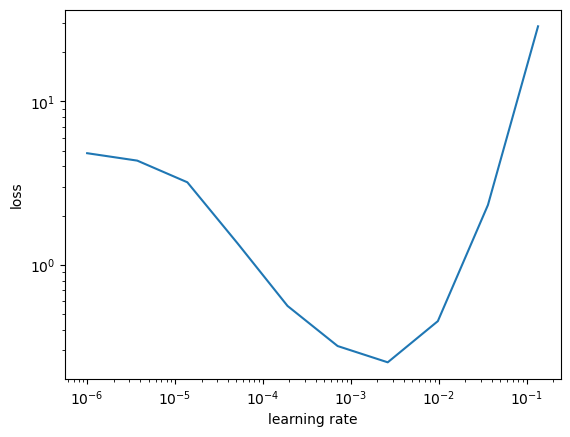

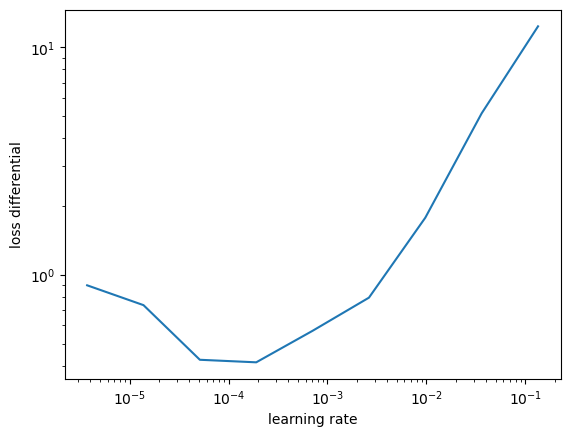

min_loss_lr 0.002626527804403768
max_drop_loss_lr 0.0001903653938715879
best_lr: 0.002626527804403768
batch size of 65536 is larger than the dataset size!
max_batch_size: 16384


In [11]:
# Find the best initial learning rate
params = {'batch_size': 4, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
min_lr = 1e-6
max_lr = 5e-1
steps = 10

model, train_losses, learning_rates, best_lr_LR = Learning_Rate_Range_Test(Linear_Regression, min_lr, max_lr, steps, params)
print("best_lr:", best_lr_LR)

# Find the maximum batch size
max_batch_size_LR = get_max_batch_size(model)

# PyTorch Linear Regression training

In [12]:
# Parameters for grid search
epochs = [5, 10, 20, 50]
batch_size = [4]
dropout_rate = [None]
lrs = [best_lr_LR]
weight_decay = [0]
batch_growths = [True, False]
loss = ["MSE"]

# Parameter formatting
all_param_vals = [epochs, batch_size, lrs, batch_growths, loss, weight_decay, dropout_rate]
feature_names = ["epochs", "batch_size", "lr", "batch_growth", "loss", "weight_decay", "dropout_rate"]
params = create_param_dict_from_lists(all_param_vals, feature_names)

print("All grid searched values:")
for param in params:
    print("\t", param)

# Grid search
best_train_params_LR, best_val_params_LR, grid_train_losses_LR, grid_val_losses_LR = grid_search(Linear_Regression, params, max_batch_size_LR)

print("Final training for the min val loss:")
model_LR, train_losses_LR, val_losses_LR = train_model(Linear_Regression, best_val_params_LR, max_batch_size_LR, print_mode=True)

All grid searched values:
	 {'epochs': 5, 'batch_size': 4, 'lr': 0.002626527804403768, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 5, 'batch_size': 4, 'lr': 0.002626527804403768, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 10, 'batch_size': 4, 'lr': 0.002626527804403768, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 10, 'batch_size': 4, 'lr': 0.002626527804403768, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 20, 'batch_size': 4, 'lr': 0.002626527804403768, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 20, 'batch_size': 4, 'lr': 0.002626527804403768, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 50, 'batch_size': 4, 'lr': 0.002626527804403768, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate':

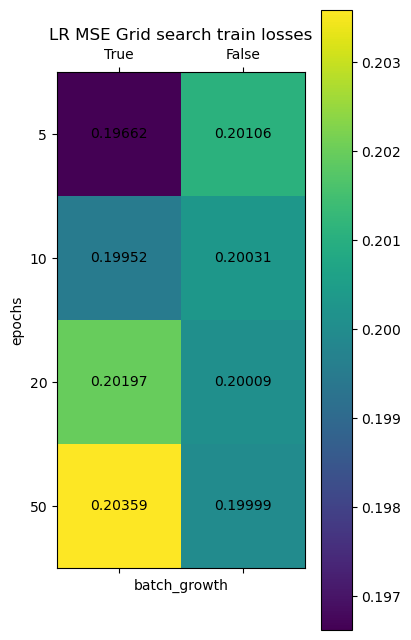

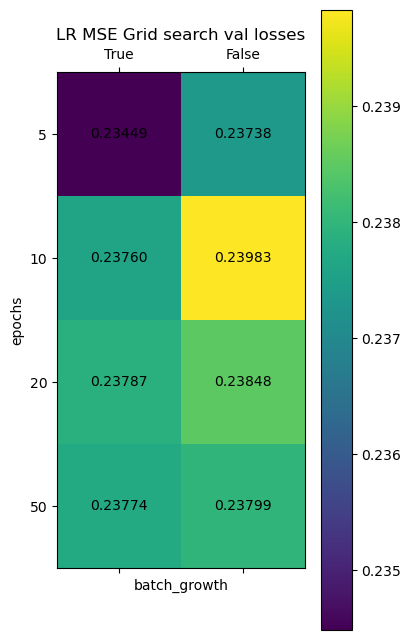

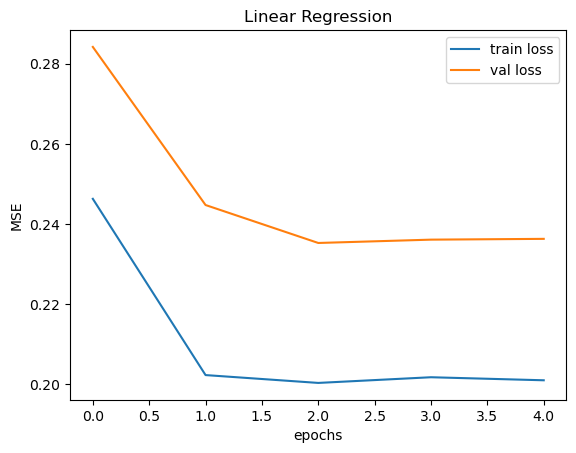

best train params:  {'epochs': 5, 'batch_size': 4, 'lr': 0.002626527804403768, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
best val params:  {'epochs': 5, 'batch_size': 4, 'lr': 0.002626527804403768, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
Train metrics:
	MSE: 0.2001372013082284
	Original scale MSE: 802150.7033921848

	RMSE: 0.44736696492726014
	Original scale RMSE: 895.6286637843749

	MAE: 0.30414763212836476
	Original scale MAE: 608.9035595209862

Validation metrics:
	MSE: 0.2363040398971715
	Original scale MSE: 947107.5371240231

	RMSE: 0.4861111394497883
	Original scale RMSE: 973.1945011784762

	MAE: 0.31928909431695324
	Original scale MAE: 639.2167668225403

Test metrics:
	MSE: 0.27767137241182965
	Original scale MSE: 1112907.9713121026

	RMSE: 0.5269453220324
	Original scale RMSE: 1054.9445347088645

	MAE: 0.3418207928135853
	Original scale MAE: 684.3252272127978


In [13]:
# Show grid search progress
train_grid = np.zeros((len(epochs), len(batch_growths)))
val_grid = np.zeros((len(epochs), len(batch_growths)))

for i in range(len(grid_val_losses_LR)):
    train_grid[i // len(batch_growths), i % len(batch_growths)] = grid_train_losses_LR[i]
    val_grid  [i // len(batch_growths), i % len(batch_growths)] = grid_val_losses_LR[i]

plot_grid(grid_values=train_grid, title="LR MSE Grid search train losses", x_label="batch_growth", y_label="epochs", x_values=batch_growths, y_values=epochs)
plot_grid(grid_values=val_grid  , title="LR MSE Grid search val losses"  , x_label="batch_growth", y_label="epochs", x_values=batch_growths, y_values=epochs)

# Plot the training progress
plot_losses(train_losses_LR, val_losses_LR, "Linear Regression")

# Show final model evaluation
print("best train params: ", best_train_params_LR)
print("best val params: ", best_val_params_LR)
evaluate_model(model_LR, max_batch_size_LR)

# PyTorch MLP implementation

In [14]:
class MLP_Regressor(nn.Module):
    def __init__(self, params):
        super(MLP_Regressor, self).__init__()

        self.hidden_size = params["hidden_size"]
        self.input_dropout_rate = params["input_dropout_rate"]
        self.hidden_dropout_rate = params["hidden_dropout_rate"]

        self.fc1 = nn.Linear(input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, 1)

        if self.input_dropout_rate != None:
            self.input_dropout = nn.Dropout(self.input_dropout_rate)
        if self.hidden_dropout_rate != None:
            self.hidden_dropout = nn.Dropout(self.hidden_dropout_rate)

    def forward(self, x):
        if self.input_dropout_rate != None:
            x = self.input_dropout(x)

        x = torch.relu(self.fc1(x))

        if self.hidden_dropout_rate != None:
            x = self.hidden_dropout(x)
        x = self.fc2(x)

        return x

gamma per epoch: 3.7144712429378357
residual: 2.9103830456733704e-10

Initial: Train loss: 0.9110752

Step:1 	Train loss: 0.8872167 	LR: 1e-08
Step:2 	Train loss: 0.8451161 	LR: 3.714471242937836e-08
Step:3 	Train loss: 0.7444041 	LR: 1.3797296614612152e-07
Step:4 	Train loss: 0.4980821 	LR: 5.124966150526039e-07
Step:5 	Train loss: 0.2779914 	LR: 1.903653938715879e-06
Step:6 	Train loss: 0.1930100 	LR: 7.071067811865478e-06
Step:7 	Train loss: 0.1705562 	LR: 2.6265278044037684e-05
Step:8 	Train loss: 0.1779023 	LR: 9.75616199823445e-05
Step:9 	Train loss: 1.6551088 	LR: 0.000362389831838848
Step:10 	Train loss: 570.1465882 	LR: 0.001346086609098479

Time to train: 233.773s


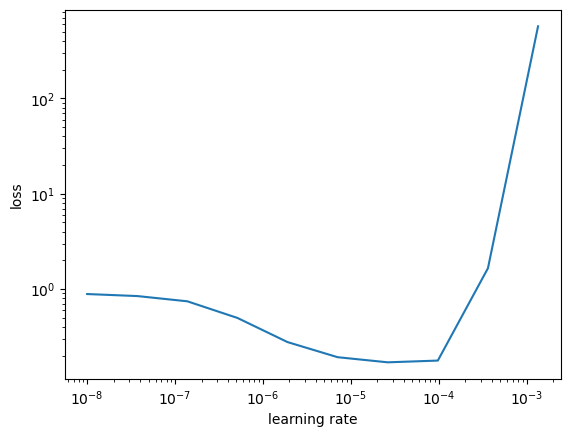

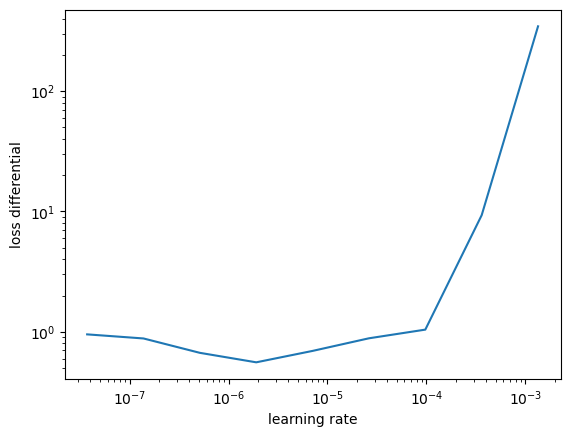

min_loss_lr 2.6265278044037684e-05
max_drop_loss_lr 1.903653938715879e-06
best_lr: 2.6265278044037684e-05
batch size of 16384 caused OOM!
max_batch_size: 4096


In [15]:
# Find the best initial learning rate
hidden_size = 100000

params = {'batch_size': 4, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': hidden_size}
min_lr = 1e-8
max_lr = 5e-3
steps = 10

model, train_losses, learning_rates, best_lr_MLP = Learning_Rate_Range_Test(MLP_Regressor, min_lr, max_lr, steps, params)
print("best_lr:", best_lr_MLP)

# Find the maximum batch size
max_batch_size_MLP = get_max_batch_size(model)

# PyTorch MLP training optimization

In [16]:
# Parameters for grid search
epochs = [20, 50, 100, 200]
batch_size = [4]
loss = ["MSE"]
lrs = [best_lr_MLP]
weight_decay = [0]
batch_growths = [True, False]

input_dropout_rate = [None]
hidden_dropout_rate = [None]
hidden_sizes = [hidden_size]

# Parameter formatting
all_param_vals = [epochs, batch_size, lrs, batch_growths, loss, weight_decay, input_dropout_rate, hidden_dropout_rate, hidden_sizes]
feature_names = ["epochs", "batch_size", "lr", "batch_growth", "loss", "weight_decay", "input_dropout_rate", "hidden_dropout_rate", "hidden_size"]
params = create_param_dict_from_lists(all_param_vals, feature_names)

print("All grid searched values:\n")
for param in params:
    print(param)

# Grid search
best_train_params_MLP, best_val_params_MLP, grid_train_losses_MLP, grid_val_losses_MLP = grid_search(MLP_Regressor, params, max_batch_size_MLP)

print("Final training for the min train loss:")
model_MLP, train_losses_MLP, val_losses_MLP = train_model(MLP_Regressor, best_train_params_MLP, max_batch_size_MLP, print_mode=True)

All grid searched values:

{'epochs': 20, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}
{'epochs': 20, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}
{'epochs': 50, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}
{'epochs': 50, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}
{'epochs': 100, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hi

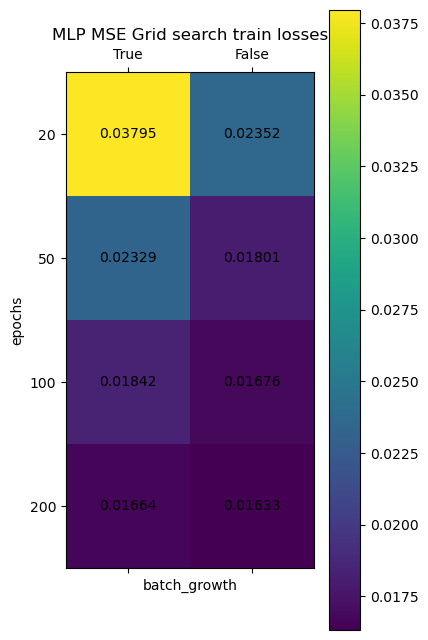

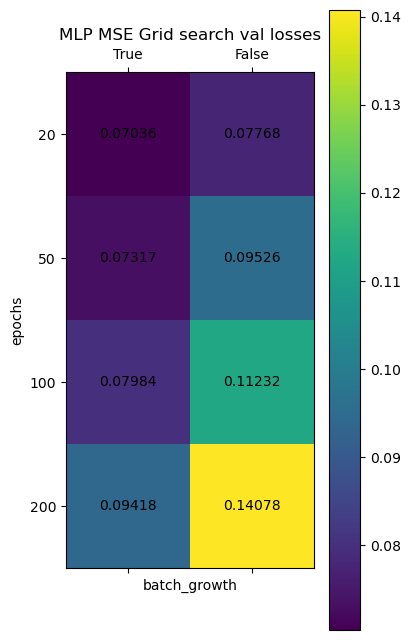

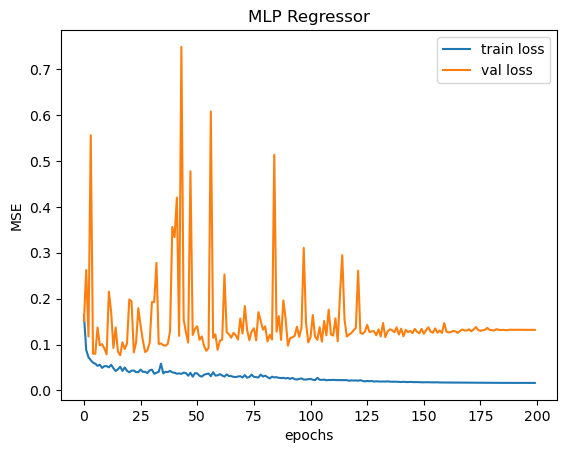

best train params:  {'epochs': 200, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}
best val params:  {'epochs': 20, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}
Train metrics:
	MSE: 0.016337509554864287
	Original scale MSE: 65480.80364593426

	RMSE: 0.12781826768840315
	Original scale RMSE: 255.89217191218307

	MAE: 0.024328316265360285
	Original scale MAE: 48.705289163251294

Validation metrics:
	MSE: 0.13188075989037806
	Original scale MSE: 528578.6131636747

	RMSE: 0.3631539066158838
	Original scale RMSE: 727.0341210449993

	MAE: 0.20970105374494286
	Original scale MAE: 419.82150959737555

Test metrics:
	MSE: 0.1383337417344775
	Original scale MSE: 554442.1902067527

	RMSE: 0.3719324424334041
	Original scale RMSE

In [17]:
# Show grid search progress
train_grid = np.zeros((len(epochs), len(batch_growths)))
val_grid = np.zeros((len(epochs), len(batch_growths)))

for i in range(len(grid_val_losses_MLP)):
    train_grid[i // len(batch_growths), i % len(batch_growths)] = grid_train_losses_MLP[i]
    val_grid  [i // len(batch_growths), i % len(batch_growths)] = grid_val_losses_MLP[i]

plot_grid(grid_values=train_grid, title="MLP MSE Grid search train losses", x_label="batch_growth", y_label="epochs", x_values=batch_growths, y_values=epochs)
plot_grid(grid_values=val_grid  , title="MLP MSE Grid search val losses"  , x_label="batch_growth", y_label="epochs", x_values=batch_growths, y_values=epochs)

# Plot the training progress
plot_losses(train_losses_MLP, val_losses_MLP, "MLP Regressor")

# Show final model evaluation
print("best train params: ", best_train_params_MLP)
print("best val params: ", best_val_params_MLP)
evaluate_model(model_MLP, max_batch_size_MLP)

# PyTorch MLP dropout optimization

In [18]:
# Parameters for grid search
epochs = [200]
batch_size = [4]
loss = ["MSE"]
lrs = [best_lr_MLP]
weight_decay = [0]
batch_growths = [True]

input_dropout_rate = [None, 0.2, 0.5]
hidden_dropout_rate = [None, 0.2, 0.5]
hidden_sizes = [hidden_size]

# Parameter formatting
all_param_vals = [epochs, batch_size, lrs, batch_growths, loss, weight_decay, input_dropout_rate, hidden_dropout_rate, hidden_sizes]
feature_names = ["epochs", "batch_size", "lr", "batch_growth", "loss", "weight_decay", "input_dropout_rate", "hidden_dropout_rate", "hidden_size"]
params = create_param_dict_from_lists(all_param_vals, feature_names)

print("All grid searched values:\n")
for param in params:
    print(param)

# Grid search
best_train_params_MLP, best_val_params_MLP, grid_train_losses_MLP, grid_val_losses_MLP = grid_search(MLP_Regressor, params, max_batch_size_MLP)

print("Final training for the min val loss:")
model_MLP, train_losses_MLP, val_losses_MLP = train_model(MLP_Regressor, best_val_params_MLP, max_batch_size_MLP, print_mode=True)

All grid searched values:

{'epochs': 200, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}
{'epochs': 200, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': 0.2, 'hidden_size': 100000}
{'epochs': 200, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': 0.5, 'hidden_size': 100000}
{'epochs': 200, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': 0.2, 'hidden_dropout_rate': None, 'hidden_size': 100000}
{'epochs': 200, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': 0.2, 'hidden_dropout_rate': 0.2, 'hidde

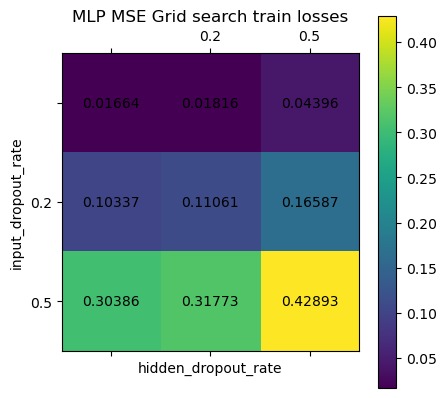

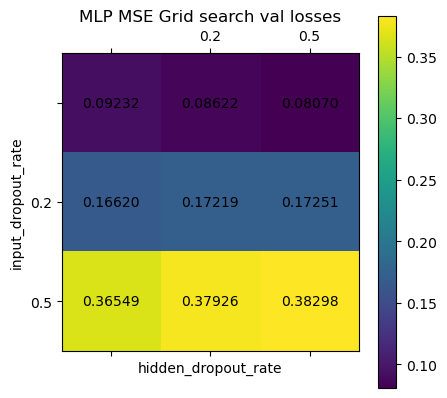

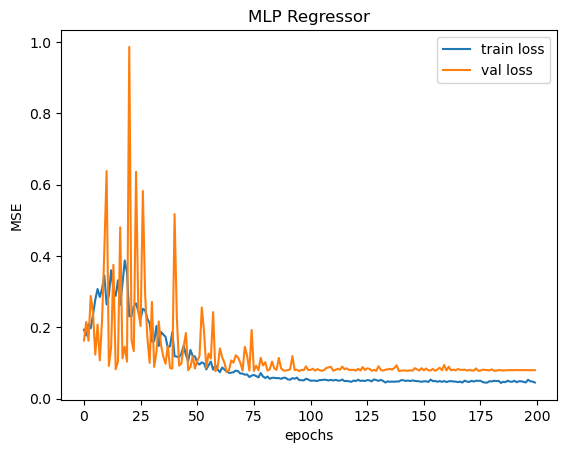

best train params:  {'epochs': 200, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}
best val params:  {'epochs': 200, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': 0.5, 'hidden_size': 100000}
Train metrics:
	MSE: 0.021836629536750182
	Original scale MSE: 87521.29852981286

	RMSE: 0.14777222180352498
	Original scale RMSE: 295.839988050657

	MAE: 0.06110525764821869
	Original scale MAE: 122.3327258117338

Validation metrics:
	MSE: 0.07985025972253183
	Original scale MSE: 320040.16036894644

	RMSE: 0.28257788257847044
	Original scale RMSE: 565.7209209220978

	MAE: 0.14173556466499287
	Original scale MAE: 283.7546004593158

Test metrics:
	MSE: 0.09014813088641707
	Original scale MSE: 361314.0691852832

	RMSE: 0.3002467833073605
	Original scale RMSE: 6

In [19]:
# Show grid search progress
train_grid = np.zeros((len(input_dropout_rate), len(hidden_dropout_rate)))
val_grid = np.zeros((len(input_dropout_rate), len(hidden_dropout_rate)))

for i in range(len(grid_val_losses_MLP)):
    train_grid[i // len(hidden_dropout_rate), i % len(hidden_dropout_rate)] = grid_train_losses_MLP[i]
    val_grid  [i // len(hidden_dropout_rate), i % len(hidden_dropout_rate)] = grid_val_losses_MLP[i]

plot_grid(grid_values=train_grid, title="MLP MSE Grid search train losses", x_label="hidden_dropout_rate", y_label="input_dropout_rate", x_values=hidden_dropout_rate, y_values=input_dropout_rate)
plot_grid(grid_values=val_grid  , title="MLP MSE Grid search val losses"  , x_label="hidden_dropout_rate", y_label="input_dropout_rate", x_values=hidden_dropout_rate, y_values=input_dropout_rate)

# Plot the training progress
plot_losses(train_losses_MLP, val_losses_MLP, "MLP Regressor")

# Show final model evaluation
print("best train params: ", best_train_params_MLP)
print("best val params: ", best_val_params_MLP)
evaluate_model(model_MLP, max_batch_size_MLP)

# More dropout and l2 optimization

In [20]:
# Parameters for grid search
input_dropout_rate = [None]
hidden_dropout_rate = [None, 0.2, 0.35, 0.5, 0.8, 0.9, 0.95]
weight_decay = [0, 1e-4, 1e-3, 1e-2, 1e-1, 1]

# Parameter formatting
all_param_vals = [epochs, batch_size, lrs, batch_growths, loss, weight_decay, input_dropout_rate, hidden_dropout_rate, hidden_sizes]
feature_names = ["epochs", "batch_size", "lr", "batch_growth", "loss", "weight_decay", "input_dropout_rate", "hidden_dropout_rate", "hidden_size"]
params = create_param_dict_from_lists(all_param_vals, feature_names)

print("All grid searched values:\n")
for param in params:
    print(param)

# Grid search
best_train_params_MLP, best_val_params_MLP, grid_train_losses_MLP, grid_val_losses_MLP = grid_search(MLP_Regressor, params, max_batch_size_MLP)

print("Final training for the min val loss:")
model_MLP, train_losses_MLP, val_losses_MLP = train_model(MLP_Regressor, best_val_params_MLP, max_batch_size_MLP, print_mode=True)

All grid searched values:

{'epochs': 200, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}
{'epochs': 200, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': 0.2, 'hidden_size': 100000}
{'epochs': 200, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': 0.35, 'hidden_size': 100000}
{'epochs': 200, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': 0.5, 'hidden_size': 100000}
{'epochs': 200, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': 0.8, 'hid

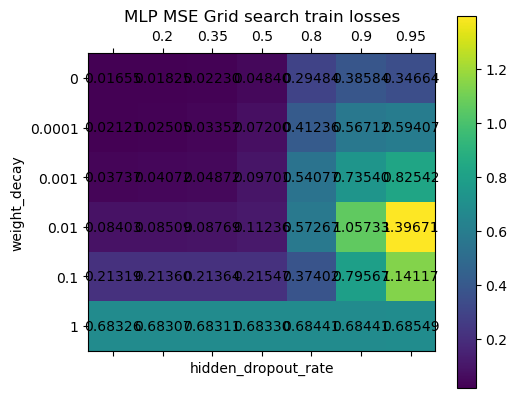

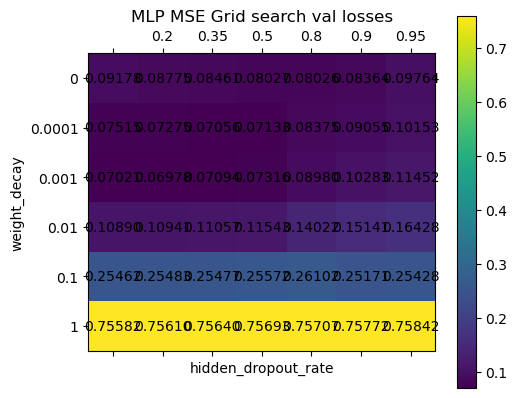

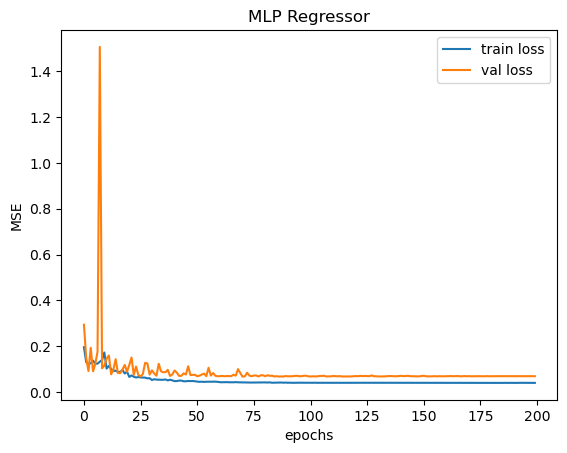

best train params:  {'epochs': 200, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}
best val params:  {'epochs': 200, 'batch_size': 4, 'lr': 2.6265278044037684e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0.001, 'input_dropout_rate': None, 'hidden_dropout_rate': 0.2, 'hidden_size': 100000}
Train metrics:
	MSE: 0.03920818206922521
	Original scale MSE: 157146.55056618297

	RMSE: 0.19801056049924512
	Original scale RMSE: 396.4171421194888

	MAE: 0.09670757127761369
	Original scale MAE: 193.60855769778263

Validation metrics:
	MSE: 0.0697166207955003
	Original scale MSE: 279424.4950148483

	RMSE: 0.2640390516486156
	Original scale RMSE: 528.6061814005284

	MAE: 0.1412538849668476
	Original scale MAE: 282.7902777036288

Test metrics:
	MSE: 0.08763270193271827
	Original scale MSE: 351232.2198771426

	RMSE: 0.2960282113797911
	Original scale RMSE:

In [21]:
# Show grid search progress
train_grid = np.zeros((len(weight_decay), len(hidden_dropout_rate)))
val_grid = np.zeros((len(weight_decay), len(hidden_dropout_rate)))

for i in range(len(grid_val_losses_MLP)):
    train_grid[i // len(hidden_dropout_rate), i % len(hidden_dropout_rate)] = grid_train_losses_MLP[i]
    val_grid  [i // len(hidden_dropout_rate), i % len(hidden_dropout_rate)] = grid_val_losses_MLP[i]

plot_grid(grid_values=train_grid, title="MLP MSE Grid search train losses", x_label="hidden_dropout_rate", y_label="weight_decay", x_values=hidden_dropout_rate, y_values=weight_decay)
plot_grid(grid_values=val_grid  , title="MLP MSE Grid search val losses"  , x_label="hidden_dropout_rate", y_label="weight_decay", x_values=hidden_dropout_rate, y_values=weight_decay)

# Plot the training progress
plot_losses(train_losses_MLP, val_losses_MLP, "MLP Regressor")

# Show final model evaluation
print("best train params: ", best_train_params_MLP)
print("best val params: ", best_val_params_MLP)
evaluate_model(model_MLP, max_batch_size_MLP)

In [23]:
#Save the final model
print("Saving model...")
path_to_save = "Final_MLP_Regressor"
torch.save(model_MLP, path_to_save)

with open('Final_MLP_Regressor_params.txt', 'w') as f:
    print(best_val_params_MLP, file=f)

Saving model...
